In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,Sequential,constraints
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Dropout,Dense,Flatten,Layer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.utils import class_weight
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from matplotlib import pyplot,colors
from scipy.stats import pearsonr

In [2]:
spectra=pd.read_csv('Spectra_Checked_baseline.csv',header=0)
print((spectra.isnull().any()).any())
X=spectra.iloc[:,1:].values
labels=pd.read_csv('Labels_Checked_baseline.csv',header=0)
Y=labels.iloc[:,1:].values
X=X.transpose()
Y=Y.transpose()
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size=0.3, random_state=42)
X_train=np.expand_dims(X_train,axis=2)
X_test=np.expand_dims(X_test,axis=2)
df=pd.read_csv('Basis_Spectra_Checked.csv',header=0)
basis=df.iloc[:,2:].values

False


In [37]:
class Lorentz_layer(Layer):
    def __init__(self, units=5,kernel_constraint=None,
               bias_constraint=None,**kwargs):
        super(Lorentz_layer,self).__init__(**kwargs)
        self.units = units
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        
    def build(self,input_shape):
        self.w = tf.Variable(name="kernel",   initial_value=90*tf.eye(input_shape[-1], num_columns=self.units,
                 dtype='float32'),constraint=self.kernel_constraint,trainable=True)
        
        b_init = tf.keras.initializers.RandomUniform(minval=0, maxval=100, seed=None)
        self.b = tf.Variable(name="bias",initial_value=b_init(shape=(self.units,), dtype='float32'),
                             constraint=self.bias_constraint,
                             trainable=True)
        self.x=(np.linspace(0,3600,901,dtype='float32')).reshape(901,1)
    
    def call(self,inputs):
        x0=tf.matmul(inputs,self.w)+K.epsilon()
        #m='-----------------------------------------'
        #tf.print(m)
        gamma=self.b+K.epsilon()
        val=(1/(np.pi*gamma))*(1/(1+(tf.subtract(self.x,tf.expand_dims(x0,axis=1))/gamma)**2))
        #val=tf.divide(tf.subtract(val, tf.reduce_min(val)), tf.subtract(tf.reduce_max(val), tf.reduce_min(val)))
        return val


In [38]:
class sum_layer(Layer):
    def __init__(self, units=1,kernel_constraint=None,
               bias_constraint=None,**kwargs):
        super(sum_layer,self).__init__(**kwargs)
        self.units = units
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
    def build(self,input_shape):
        w_init = tf.keras.initializers.RandomUniform(minval=0.01, maxval=1, seed=None)
        self.w = tf.Variable(name="kernel",   initial_value=w_init(shape=(input_shape[-1], self.units),
                 dtype='float32'),constraint=self.kernel_constraint,trainable=True)
        
        self.b = None
    def call(self,inputs):
        val=tf.matmul(inputs,self.w)
    
        val=tf.divide(tf.subtract(val, tf.reduce_min(val)), tf.subtract(tf.reduce_max(val), tf.reduce_min(val))+K.epsilon())
        return val

In [43]:
my_layer=Lorentz_layer(units=20,kernel_constraint=constraints.NonNeg(),bias_constraint=constraints.NonNeg())
final_layer=sum_layer(kernel_constraint=constraints.NonNeg())
Input_layer=keras.Input(shape=(901,1))
conv1=Conv1D(filters=10, kernel_size=5,activation='relu',padding='same')
pool1=MaxPooling1D()
pool2=MaxPooling1D()
conv2=Conv1D(filters=10, kernel_size=5,activation='relu',padding='same')
drop=Dropout(0.2)
flat=Flatten()
Dense1=Dense(20,activation='relu')
Dense2=Dense(15,activation='relu')
Dense3=Dense(20,activation='relu',name='X0')
Sig=Dense(13,activation='sigmoid',name='Labels')
x=conv1(Input_layer)
x=pool1(x)
x=conv2(x)
x=pool2(x)
x=drop(x)
x=flat(x)
x=Dense1(x)
x=Dense2(x)
op_label=Sig(x)
y=Dense3(op_label)
spec=my_layer(y)
op_spec=final_layer(spec)

model=keras.Model(Input_layer,[op_label,op_spec])
model.summary()



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 901, 1)]          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 901, 10)           60        
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 450, 10)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 450, 10)           510       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 225, 10)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 225, 10)           0   

In [40]:
def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', classes=[0.,1.], y=y_true[:, i])
    return weights
weights=calculating_class_weights(y_train)
print(weights)
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        y_true=tf.cast(y_true,tf.float32)
        y_pred=tf.cast(y_pred,tf.float32)
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

[[ 3.21286307  0.59215356]
 [ 0.57663092  3.76239067]
 [ 0.51149425 22.25      ]
 [ 1.22554606  0.84456806]
 [ 0.5482158   5.68502203]
 [ 0.51217092 21.04076087]
 [ 0.56700351  4.23114754]
 [ 0.53651608  7.34629981]
 [ 0.5258047  10.18815789]
 [ 0.57749105  3.72617902]
 [ 0.56222771  4.51750292]
 [ 0.66406518  2.02378463]
 [ 0.52874898  9.195962  ]]


In [41]:
def KLDerror(y_true,y_pred):
    x=K.softmax(y_true,axis=1)
    y=K.softmax(y_pred,axis=1)
    #x = K.clip(x, K.epsilon(), 1)
    #y = K.clip(y, K.epsilon(), 1)
    kl=keras.losses.KLDivergence()
    return kl(x,y)

In [44]:
model.compile(loss=[get_weighted_loss(weights),KLDerror],optimizer='adam',loss_weights=[1,1000])
history=model.fit(X_train,[y_train,X_train],epochs=3000,verbose=1)

Epoch 1/3000
242/242 [==============================] - 6s 19ms/step - loss: 0.5815 - Labels_loss: 0.5587 - sum_layer_3_loss: 2.2800e-05
Epoch 2/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.4539 - Labels_loss: 0.4326 - sum_layer_3_loss: 2.1296e-05
Epoch 3/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.4066 - Labels_loss: 0.3864 - sum_layer_3_loss: 2.0205e-05
Epoch 4/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.3808 - Labels_loss: 0.3611 - sum_layer_3_loss: 1.9698e-05
Epoch 5/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.3648 - Labels_loss: 0.3452 - sum_layer_3_loss: 1.9584e-05
Epoch 6/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.3518 - Labels_loss: 0.3323 - sum_layer_3_loss: 1.9522e-05
Epoch 7/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.3413 - Labels_loss: 0.3218 - sum_layer_3_loss: 1.9464e-05
Epoch 8/3000
242/242 [===================

242/242 [==============================] - 4s 19ms/step - loss: 0.2067 - Labels_loss: 0.1893 - sum_layer_3_loss: 1.7381e-05
Epoch 61/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.2016 - Labels_loss: 0.1843 - sum_layer_3_loss: 1.7358e-05
Epoch 62/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.2042 - Labels_loss: 0.1868 - sum_layer_3_loss: 1.7359e-05
Epoch 63/3000
242/242 [==============================] - 4s 19ms/step - loss: 0.2022 - Labels_loss: 0.1849 - sum_layer_3_loss: 1.7352e-05
Epoch 64/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.2001 - Labels_loss: 0.1828 - sum_layer_3_loss: 1.7350e-05
Epoch 65/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.2008 - Labels_loss: 0.1835 - sum_layer_3_loss: 1.7325e-05
Epoch 66/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.2009 - Labels_loss: 0.1836 - sum_layer_3_loss: 1.7339e-05
Epoch 67/3000
242/242 [=========================

242/242 [==============================] - 5s 19ms/step - loss: 0.1684 - Labels_loss: 0.1517 - sum_layer_3_loss: 1.6687e-05
Epoch 120/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1714 - Labels_loss: 0.1548 - sum_layer_3_loss: 1.6650e-05
Epoch 121/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1690 - Labels_loss: 0.1523 - sum_layer_3_loss: 1.6698e-05
Epoch 122/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1725 - Labels_loss: 0.1558 - sum_layer_3_loss: 1.6718e-05
Epoch 123/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1683 - Labels_loss: 0.1516 - sum_layer_3_loss: 1.6656e-05
Epoch 124/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1665 - Labels_loss: 0.1499 - sum_layer_3_loss: 1.6664e-05
Epoch 125/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1690 - Labels_loss: 0.1524 - sum_layer_3_loss: 1.6647e-05
Epoch 126/3000
242/242 [==================

242/242 [==============================] - 5s 19ms/step - loss: 0.1548 - Labels_loss: 0.1385 - sum_layer_3_loss: 1.6281e-05
Epoch 179/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1585 - Labels_loss: 0.1422 - sum_layer_3_loss: 1.6308e-05
Epoch 180/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1571 - Labels_loss: 0.1408 - sum_layer_3_loss: 1.6282e-05
Epoch 181/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1544 - Labels_loss: 0.1381 - sum_layer_3_loss: 1.6299e-05
Epoch 182/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1543 - Labels_loss: 0.1381 - sum_layer_3_loss: 1.6276e-05
Epoch 183/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1515 - Labels_loss: 0.1352 - sum_layer_3_loss: 1.6275e-05
Epoch 184/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1564 - Labels_loss: 0.1401 - sum_layer_3_loss: 1.6294e-05
Epoch 185/3000
242/242 [==================

242/242 [==============================] - 5s 19ms/step - loss: 0.1424 - Labels_loss: 0.1262 - sum_layer_3_loss: 1.6251e-05
Epoch 238/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1417 - Labels_loss: 0.1254 - sum_layer_3_loss: 1.6217e-05
Epoch 239/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1415 - Labels_loss: 0.1253 - sum_layer_3_loss: 1.6197e-05
Epoch 240/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1404 - Labels_loss: 0.1242 - sum_layer_3_loss: 1.6194e-05
Epoch 241/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1514 - Labels_loss: 0.1351 - sum_layer_3_loss: 1.6240e-05
Epoch 242/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1480 - Labels_loss: 0.1318 - sum_layer_3_loss: 1.6221e-05
Epoch 243/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1420 - Labels_loss: 0.1258 - sum_layer_3_loss: 1.6206e-05
Epoch 244/3000
242/242 [==================

242/242 [==============================] - 5s 19ms/step - loss: 0.1385 - Labels_loss: 0.1224 - sum_layer_3_loss: 1.6129e-05
Epoch 297/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1320 - Labels_loss: 0.1159 - sum_layer_3_loss: 1.6125e-05
Epoch 298/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1322 - Labels_loss: 0.1161 - sum_layer_3_loss: 1.6143e-05
Epoch 299/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1342 - Labels_loss: 0.1180 - sum_layer_3_loss: 1.6148e-05
Epoch 300/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1290 - Labels_loss: 0.1129 - sum_layer_3_loss: 1.6130e-05
Epoch 301/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1332 - Labels_loss: 0.1171 - sum_layer_3_loss: 1.6131e-05
Epoch 302/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1312 - Labels_loss: 0.1151 - sum_layer_3_loss: 1.6100e-05
Epoch 303/3000
242/242 [==================

242/242 [==============================] - 5s 19ms/step - loss: 0.1265 - Labels_loss: 0.1104 - sum_layer_3_loss: 1.6022e-05
Epoch 356/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1277 - Labels_loss: 0.1117 - sum_layer_3_loss: 1.6016e-05
Epoch 357/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1219 - Labels_loss: 0.1058 - sum_layer_3_loss: 1.6071e-05
Epoch 358/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1300 - Labels_loss: 0.1140 - sum_layer_3_loss: 1.6028e-05
Epoch 359/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1250 - Labels_loss: 0.1090 - sum_layer_3_loss: 1.6022e-05
Epoch 360/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1258 - Labels_loss: 0.1098 - sum_layer_3_loss: 1.6015e-05
Epoch 361/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1328 - Labels_loss: 0.1167 - sum_layer_3_loss: 1.6082e-05
Epoch 362/3000
242/242 [==================

242/242 [==============================] - 5s 19ms/step - loss: 0.1246 - Labels_loss: 0.1087 - sum_layer_3_loss: 1.5913e-05
Epoch 415/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1185 - Labels_loss: 0.1027 - sum_layer_3_loss: 1.5880e-05
Epoch 416/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1237 - Labels_loss: 0.1078 - sum_layer_3_loss: 1.5889e-05
Epoch 417/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1233 - Labels_loss: 0.1075 - sum_layer_3_loss: 1.5882e-05
Epoch 418/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1244 - Labels_loss: 0.1086 - sum_layer_3_loss: 1.5880e-05
Epoch 419/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1297 - Labels_loss: 0.1137 - sum_layer_3_loss: 1.5918e-05
Epoch 420/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1213 - Labels_loss: 0.1054 - sum_layer_3_loss: 1.5894e-05
Epoch 421/3000
242/242 [==================

242/242 [==============================] - 5s 19ms/step - loss: 0.1138 - Labels_loss: 0.0979 - sum_layer_3_loss: 1.5871e-05
Epoch 474/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1172 - Labels_loss: 0.1014 - sum_layer_3_loss: 1.5849e-05
Epoch 475/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1205 - Labels_loss: 0.1047 - sum_layer_3_loss: 1.5839e-05
Epoch 476/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1174 - Labels_loss: 0.1015 - sum_layer_3_loss: 1.5910e-05
Epoch 477/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1193 - Labels_loss: 0.1034 - sum_layer_3_loss: 1.5831e-05
Epoch 478/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1147 - Labels_loss: 0.0988 - sum_layer_3_loss: 1.5831e-05
Epoch 479/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1205 - Labels_loss: 0.1047 - sum_layer_3_loss: 1.5825e-05
Epoch 480/3000
242/242 [==================

242/242 [==============================] - 5s 19ms/step - loss: 0.1128 - Labels_loss: 0.0969 - sum_layer_3_loss: 1.5876e-05
Epoch 533/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1183 - Labels_loss: 0.1025 - sum_layer_3_loss: 1.5840e-05
Epoch 534/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1112 - Labels_loss: 0.0953 - sum_layer_3_loss: 1.5837e-05
Epoch 535/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1132 - Labels_loss: 0.0973 - sum_layer_3_loss: 1.5847e-05
Epoch 536/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1158 - Labels_loss: 0.1000 - sum_layer_3_loss: 1.5818e-05
Epoch 537/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1157 - Labels_loss: 0.0998 - sum_layer_3_loss: 1.5853e-05
Epoch 538/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1144 - Labels_loss: 0.0986 - sum_layer_3_loss: 1.5833e-05
Epoch 539/3000
242/242 [==================

242/242 [==============================] - 5s 19ms/step - loss: 0.1063 - Labels_loss: 0.0905 - sum_layer_3_loss: 1.5821e-05
Epoch 592/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1089 - Labels_loss: 0.0931 - sum_layer_3_loss: 1.5793e-05
Epoch 593/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1097 - Labels_loss: 0.0938 - sum_layer_3_loss: 1.5832e-05
Epoch 594/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1082 - Labels_loss: 0.0924 - sum_layer_3_loss: 1.5835e-05
Epoch 595/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1122 - Labels_loss: 0.0964 - sum_layer_3_loss: 1.5812e-05
Epoch 596/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1101 - Labels_loss: 0.0943 - sum_layer_3_loss: 1.5823e-05
Epoch 597/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1066 - Labels_loss: 0.0908 - sum_layer_3_loss: 1.5844e-05
Epoch 598/3000
242/242 [==================

242/242 [==============================] - 5s 19ms/step - loss: 0.1174 - Labels_loss: 0.1016 - sum_layer_3_loss: 1.5824e-05
Epoch 651/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1068 - Labels_loss: 0.0909 - sum_layer_3_loss: 1.5811e-05
Epoch 652/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1040 - Labels_loss: 0.0882 - sum_layer_3_loss: 1.5809e-05
Epoch 653/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1102 - Labels_loss: 0.0944 - sum_layer_3_loss: 1.5795e-05
Epoch 654/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1141 - Labels_loss: 0.0982 - sum_layer_3_loss: 1.5881e-05
Epoch 655/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1133 - Labels_loss: 0.0974 - sum_layer_3_loss: 1.5825e-05
Epoch 656/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1084 - Labels_loss: 0.0926 - sum_layer_3_loss: 1.5808e-05
Epoch 657/3000
242/242 [==================

242/242 [==============================] - 5s 19ms/step - loss: 0.1056 - Labels_loss: 0.0899 - sum_layer_3_loss: 1.5780e-05
Epoch 710/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1069 - Labels_loss: 0.0911 - sum_layer_3_loss: 1.5787e-05
Epoch 711/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1011 - Labels_loss: 0.0853 - sum_layer_3_loss: 1.5784e-05
Epoch 712/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1286 - Labels_loss: 0.1128 - sum_layer_3_loss: 1.5816e-05
Epoch 713/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1127 - Labels_loss: 0.0969 - sum_layer_3_loss: 1.5818e-05
Epoch 714/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1049 - Labels_loss: 0.0891 - sum_layer_3_loss: 1.5797e-05
Epoch 715/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1028 - Labels_loss: 0.0870 - sum_layer_3_loss: 1.5792e-05
Epoch 716/3000
242/242 [==================

242/242 [==============================] - 5s 19ms/step - loss: 0.1042 - Labels_loss: 0.0884 - sum_layer_3_loss: 1.5853e-05
Epoch 769/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0988 - Labels_loss: 0.0830 - sum_layer_3_loss: 1.5791e-05
Epoch 770/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1017 - Labels_loss: 0.0859 - sum_layer_3_loss: 1.5787e-05
Epoch 771/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1040 - Labels_loss: 0.0883 - sum_layer_3_loss: 1.5774e-05
Epoch 772/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1014 - Labels_loss: 0.0856 - sum_layer_3_loss: 1.5796e-05
Epoch 773/3000
242/242 [==============================] - 4s 19ms/step - loss: 0.1003 - Labels_loss: 0.0845 - sum_layer_3_loss: 1.5800e-05
Epoch 774/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0998 - Labels_loss: 0.0841 - sum_layer_3_loss: 1.5778e-05
Epoch 775/3000
242/242 [==================

242/242 [==============================] - 5s 19ms/step - loss: 0.0984 - Labels_loss: 0.0826 - sum_layer_3_loss: 1.5751e-05
Epoch 828/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0989 - Labels_loss: 0.0832 - sum_layer_3_loss: 1.5744e-05
Epoch 829/3000
242/242 [==============================] - 4s 18ms/step - loss: 0.1030 - Labels_loss: 0.0873 - sum_layer_3_loss: 1.5759e-05
Epoch 830/3000
242/242 [==============================] - 4s 19ms/step - loss: 0.0983 - Labels_loss: 0.0826 - sum_layer_3_loss: 1.5754e-05
Epoch 831/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1070 - Labels_loss: 0.0913 - sum_layer_3_loss: 1.5739e-05
Epoch 832/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1004 - Labels_loss: 0.0846 - sum_layer_3_loss: 1.5758e-05
Epoch 833/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1038 - Labels_loss: 0.0880 - sum_layer_3_loss: 1.5760e-05
Epoch 834/3000
242/242 [==================

242/242 [==============================] - 5s 19ms/step - loss: 0.0971 - Labels_loss: 0.0814 - sum_layer_3_loss: 1.5738e-05
Epoch 887/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1022 - Labels_loss: 0.0864 - sum_layer_3_loss: 1.5752e-05
Epoch 888/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.1076 - Labels_loss: 0.0918 - sum_layer_3_loss: 1.5757e-05
Epoch 889/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0993 - Labels_loss: 0.0836 - sum_layer_3_loss: 1.5714e-05
Epoch 890/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0969 - Labels_loss: 0.0812 - sum_layer_3_loss: 1.5705e-05
Epoch 891/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0951 - Labels_loss: 0.0794 - sum_layer_3_loss: 1.5724e-05
Epoch 892/3000
242/242 [==============================] - 4s 19ms/step - loss: 0.1012 - Labels_loss: 0.0855 - sum_layer_3_loss: 1.5728e-05
Epoch 893/3000
242/242 [==================

242/242 [==============================] - 5s 19ms/step - loss: 0.0962 - Labels_loss: 0.0805 - sum_layer_3_loss: 1.5679e-05
Epoch 946/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0967 - Labels_loss: 0.0810 - sum_layer_3_loss: 1.5684e-05
Epoch 947/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0957 - Labels_loss: 0.0800 - sum_layer_3_loss: 1.5657e-05
Epoch 948/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0942 - Labels_loss: 0.0785 - sum_layer_3_loss: 1.5682e-05
Epoch 949/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0931 - Labels_loss: 0.0774 - sum_layer_3_loss: 1.5686e-05
Epoch 950/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0950 - Labels_loss: 0.0793 - sum_layer_3_loss: 1.5671e-05
Epoch 951/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0957 - Labels_loss: 0.0800 - sum_layer_3_loss: 1.5662e-05
Epoch 952/3000
242/242 [==================

242/242 [==============================] - 5s 19ms/step - loss: 0.0939 - Labels_loss: 0.0782 - sum_layer_3_loss: 1.5621e-05
Epoch 1005/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0983 - Labels_loss: 0.0826 - sum_layer_3_loss: 1.5635e-05
Epoch 1006/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0923 - Labels_loss: 0.0767 - sum_layer_3_loss: 1.5610e-05
Epoch 1007/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0967 - Labels_loss: 0.0811 - sum_layer_3_loss: 1.5633e-05
Epoch 1008/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0937 - Labels_loss: 0.0781 - sum_layer_3_loss: 1.5650e-05
Epoch 1009/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0941 - Labels_loss: 0.0785 - sum_layer_3_loss: 1.5625e-05
Epoch 1010/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0948 - Labels_loss: 0.0792 - sum_layer_3_loss: 1.5620e-05
Epoch 1011/3000
242/242 [===========

242/242 [==============================] - 5s 19ms/step - loss: 0.0886 - Labels_loss: 0.0730 - sum_layer_3_loss: 1.5590e-05
Epoch 1063/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0988 - Labels_loss: 0.0832 - sum_layer_3_loss: 1.5629e-05
Epoch 1064/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0918 - Labels_loss: 0.0762 - sum_layer_3_loss: 1.5614e-05
Epoch 1065/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0921 - Labels_loss: 0.0764 - sum_layer_3_loss: 1.5648e-05
Epoch 1066/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0931 - Labels_loss: 0.0775 - sum_layer_3_loss: 1.5624e-05
Epoch 1067/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0920 - Labels_loss: 0.0764 - sum_layer_3_loss: 1.5617e-05
Epoch 1068/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0932 - Labels_loss: 0.0775 - sum_layer_3_loss: 1.5649e-05
Epoch 1069/3000
242/242 [===========

242/242 [==============================] - 5s 19ms/step - loss: 0.0931 - Labels_loss: 0.0775 - sum_layer_3_loss: 1.5622e-05
Epoch 1121/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0907 - Labels_loss: 0.0750 - sum_layer_3_loss: 1.5654e-05
Epoch 1122/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0873 - Labels_loss: 0.0717 - sum_layer_3_loss: 1.5610e-05
Epoch 1123/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0888 - Labels_loss: 0.0732 - sum_layer_3_loss: 1.5596e-05
Epoch 1124/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0909 - Labels_loss: 0.0752 - sum_layer_3_loss: 1.5620e-05
Epoch 1125/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0941 - Labels_loss: 0.0785 - sum_layer_3_loss: 1.5626e-05
Epoch 1126/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0896 - Labels_loss: 0.0740 - sum_layer_3_loss: 1.5601e-05
Epoch 1127/3000
242/242 [===========

242/242 [==============================] - 5s 19ms/step - loss: 0.0874 - Labels_loss: 0.0718 - sum_layer_3_loss: 1.5599e-05
Epoch 1179/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0912 - Labels_loss: 0.0756 - sum_layer_3_loss: 1.5607e-05
Epoch 1180/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0852 - Labels_loss: 0.0696 - sum_layer_3_loss: 1.5620e-05
Epoch 1181/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0893 - Labels_loss: 0.0737 - sum_layer_3_loss: 1.5614e-05
Epoch 1182/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0912 - Labels_loss: 0.0756 - sum_layer_3_loss: 1.5590e-05
Epoch 1183/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0905 - Labels_loss: 0.0749 - sum_layer_3_loss: 1.5597e-05
Epoch 1184/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0888 - Labels_loss: 0.0731 - sum_layer_3_loss: 1.5638e-05
Epoch 1185/3000
242/242 [===========

242/242 [==============================] - 5s 19ms/step - loss: 0.0891 - Labels_loss: 0.0735 - sum_layer_3_loss: 1.5599e-05
Epoch 1237/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0886 - Labels_loss: 0.0730 - sum_layer_3_loss: 1.5620e-05
Epoch 1238/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0883 - Labels_loss: 0.0727 - sum_layer_3_loss: 1.5606e-05
Epoch 1239/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0896 - Labels_loss: 0.0740 - sum_layer_3_loss: 1.5615e-05
Epoch 1240/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0888 - Labels_loss: 0.0732 - sum_layer_3_loss: 1.5593e-05
Epoch 1241/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0869 - Labels_loss: 0.0713 - sum_layer_3_loss: 1.5627e-05
Epoch 1242/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0863 - Labels_loss: 0.0707 - sum_layer_3_loss: 1.5592e-05
Epoch 1243/3000
242/242 [===========

242/242 [==============================] - 5s 19ms/step - loss: 0.0845 - Labels_loss: 0.0690 - sum_layer_3_loss: 1.5582e-05
Epoch 1295/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0884 - Labels_loss: 0.0728 - sum_layer_3_loss: 1.5591e-05
Epoch 1296/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0858 - Labels_loss: 0.0702 - sum_layer_3_loss: 1.5593e-05
Epoch 1297/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0878 - Labels_loss: 0.0722 - sum_layer_3_loss: 1.5600e-05
Epoch 1298/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0875 - Labels_loss: 0.0718 - sum_layer_3_loss: 1.5628e-05
Epoch 1299/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0881 - Labels_loss: 0.0724 - sum_layer_3_loss: 1.5611e-05
Epoch 1300/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0895 - Labels_loss: 0.0739 - sum_layer_3_loss: 1.5588e-05
Epoch 1301/3000
242/242 [===========

242/242 [==============================] - 5s 19ms/step - loss: 0.0868 - Labels_loss: 0.0712 - sum_layer_3_loss: 1.5594e-05
Epoch 1353/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0828 - Labels_loss: 0.0672 - sum_layer_3_loss: 1.5574e-05
Epoch 1354/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0836 - Labels_loss: 0.0680 - sum_layer_3_loss: 1.5601e-05
Epoch 1355/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0865 - Labels_loss: 0.0709 - sum_layer_3_loss: 1.5616e-05
Epoch 1356/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0866 - Labels_loss: 0.0711 - sum_layer_3_loss: 1.5574e-05
Epoch 1357/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0897 - Labels_loss: 0.0741 - sum_layer_3_loss: 1.5600e-05
Epoch 1358/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0896 - Labels_loss: 0.0740 - sum_layer_3_loss: 1.5630e-05
Epoch 1359/3000
242/242 [===========

242/242 [==============================] - 5s 19ms/step - loss: 0.0844 - Labels_loss: 0.0688 - sum_layer_3_loss: 1.5606e-05
Epoch 1411/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0847 - Labels_loss: 0.0691 - sum_layer_3_loss: 1.5589e-05
Epoch 1412/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0851 - Labels_loss: 0.0695 - sum_layer_3_loss: 1.5581e-05
Epoch 1413/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0845 - Labels_loss: 0.0689 - sum_layer_3_loss: 1.5559e-05
Epoch 1414/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0828 - Labels_loss: 0.0672 - sum_layer_3_loss: 1.5627e-05
Epoch 1415/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0833 - Labels_loss: 0.0676 - sum_layer_3_loss: 1.5621e-05
Epoch 1416/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0870 - Labels_loss: 0.0714 - sum_layer_3_loss: 1.5582e-05
Epoch 1417/3000
242/242 [===========

242/242 [==============================] - 5s 19ms/step - loss: 0.0836 - Labels_loss: 0.0680 - sum_layer_3_loss: 1.5585e-05
Epoch 1469/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0823 - Labels_loss: 0.0667 - sum_layer_3_loss: 1.5566e-05
Epoch 1470/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0858 - Labels_loss: 0.0702 - sum_layer_3_loss: 1.5590e-05
Epoch 1471/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0816 - Labels_loss: 0.0661 - sum_layer_3_loss: 1.5592e-05
Epoch 1472/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0862 - Labels_loss: 0.0707 - sum_layer_3_loss: 1.5584e-05
Epoch 1473/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0855 - Labels_loss: 0.0699 - sum_layer_3_loss: 1.5575e-05
Epoch 1474/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0853 - Labels_loss: 0.0697 - sum_layer_3_loss: 1.5566e-05
Epoch 1475/3000
242/242 [===========

242/242 [==============================] - 5s 19ms/step - loss: 0.0847 - Labels_loss: 0.0691 - sum_layer_3_loss: 1.5585e-05
Epoch 1527/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0835 - Labels_loss: 0.0679 - sum_layer_3_loss: 1.5581e-05
Epoch 1528/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0835 - Labels_loss: 0.0680 - sum_layer_3_loss: 1.5582e-05
Epoch 1529/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0855 - Labels_loss: 0.0700 - sum_layer_3_loss: 1.5579e-05
Epoch 1530/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0833 - Labels_loss: 0.0677 - sum_layer_3_loss: 1.5586e-05
Epoch 1531/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0804 - Labels_loss: 0.0648 - sum_layer_3_loss: 1.5595e-05
Epoch 1532/3000
242/242 [==============================] - 5s 19ms/step - loss: 0.0817 - Labels_loss: 0.0662 - sum_layer_3_loss: 1.5553e-05
Epoch 1533/3000
242/242 [===========

242/242 [==============================] - 5s 20ms/step - loss: 0.0801 - Labels_loss: 0.0645 - sum_layer_3_loss: 1.5556e-05
Epoch 1585/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0821 - Labels_loss: 0.0665 - sum_layer_3_loss: 1.5579e-05
Epoch 1586/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0871 - Labels_loss: 0.0716 - sum_layer_3_loss: 1.5578e-05
Epoch 1587/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0822 - Labels_loss: 0.0666 - sum_layer_3_loss: 1.5608e-05
Epoch 1588/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0817 - Labels_loss: 0.0661 - sum_layer_3_loss: 1.5581e-05
Epoch 1589/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0845 - Labels_loss: 0.0689 - sum_layer_3_loss: 1.5589e-05
Epoch 1590/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0815 - Labels_loss: 0.0660 - sum_layer_3_loss: 1.5561e-05
Epoch 1591/3000
242/242 [===========

242/242 [==============================] - 5s 20ms/step - loss: 0.0805 - Labels_loss: 0.0650 - sum_layer_3_loss: 1.5550e-05
Epoch 1643/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0817 - Labels_loss: 0.0661 - sum_layer_3_loss: 1.5544e-05
Epoch 1644/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0815 - Labels_loss: 0.0659 - sum_layer_3_loss: 1.5591e-05
Epoch 1645/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0813 - Labels_loss: 0.0658 - sum_layer_3_loss: 1.5577e-05
Epoch 1646/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0782 - Labels_loss: 0.0626 - sum_layer_3_loss: 1.5571e-05
Epoch 1647/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0908 - Labels_loss: 0.0751 - sum_layer_3_loss: 1.5639e-05
Epoch 1648/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0810 - Labels_loss: 0.0654 - sum_layer_3_loss: 1.5568e-05
Epoch 1649/3000
242/242 [===========

242/242 [==============================] - 5s 20ms/step - loss: 0.0821 - Labels_loss: 0.0666 - sum_layer_3_loss: 1.5558e-05
Epoch 1701/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0798 - Labels_loss: 0.0642 - sum_layer_3_loss: 1.5569e-05
Epoch 1702/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0788 - Labels_loss: 0.0632 - sum_layer_3_loss: 1.5550e-05
Epoch 1703/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0788 - Labels_loss: 0.0632 - sum_layer_3_loss: 1.5552e-05
Epoch 1704/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0773 - Labels_loss: 0.0618 - sum_layer_3_loss: 1.5552e-05
Epoch 1705/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0852 - Labels_loss: 0.0696 - sum_layer_3_loss: 1.5569e-05
Epoch 1706/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0859 - Labels_loss: 0.0703 - sum_layer_3_loss: 1.5565e-05
Epoch 1707/3000
242/242 [===========

242/242 [==============================] - 5s 20ms/step - loss: 0.0816 - Labels_loss: 0.0661 - sum_layer_3_loss: 1.5537e-05
Epoch 1759/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0798 - Labels_loss: 0.0642 - sum_layer_3_loss: 1.5548e-05
Epoch 1760/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0819 - Labels_loss: 0.0663 - sum_layer_3_loss: 1.5568e-05
Epoch 1761/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0793 - Labels_loss: 0.0638 - sum_layer_3_loss: 1.5540e-05
Epoch 1762/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0799 - Labels_loss: 0.0643 - sum_layer_3_loss: 1.5527e-05
Epoch 1763/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0784 - Labels_loss: 0.0629 - sum_layer_3_loss: 1.5585e-05
Epoch 1764/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0802 - Labels_loss: 0.0646 - sum_layer_3_loss: 1.5575e-05
Epoch 1765/3000
242/242 [===========

242/242 [==============================] - 5s 20ms/step - loss: 0.0796 - Labels_loss: 0.0640 - sum_layer_3_loss: 1.5570e-05
Epoch 1817/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0770 - Labels_loss: 0.0614 - sum_layer_3_loss: 1.5589e-05
Epoch 1818/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0792 - Labels_loss: 0.0637 - sum_layer_3_loss: 1.5568e-05
Epoch 1819/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0749 - Labels_loss: 0.0594 - sum_layer_3_loss: 1.5528e-05
Epoch 1820/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0874 - Labels_loss: 0.0719 - sum_layer_3_loss: 1.5562e-05
Epoch 1821/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0790 - Labels_loss: 0.0635 - sum_layer_3_loss: 1.5551e-05
Epoch 1822/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0848 - Labels_loss: 0.0692 - sum_layer_3_loss: 1.5572e-05
Epoch 1823/3000
242/242 [===========

242/242 [==============================] - 5s 20ms/step - loss: 0.0812 - Labels_loss: 0.0657 - sum_layer_3_loss: 1.5549e-05
Epoch 1875/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0785 - Labels_loss: 0.0629 - sum_layer_3_loss: 1.5555e-05
Epoch 1876/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0769 - Labels_loss: 0.0613 - sum_layer_3_loss: 1.5552e-05
Epoch 1877/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0771 - Labels_loss: 0.0616 - sum_layer_3_loss: 1.5541e-05
Epoch 1878/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0811 - Labels_loss: 0.0656 - sum_layer_3_loss: 1.5547e-05
Epoch 1879/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0763 - Labels_loss: 0.0607 - sum_layer_3_loss: 1.5568e-05
Epoch 1880/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0808 - Labels_loss: 0.0652 - sum_layer_3_loss: 1.5523e-05
Epoch 1881/3000
242/242 [===========

242/242 [==============================] - 5s 20ms/step - loss: 0.0833 - Labels_loss: 0.0677 - sum_layer_3_loss: 1.5588e-05
Epoch 1933/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0789 - Labels_loss: 0.0633 - sum_layer_3_loss: 1.5541e-05
Epoch 1934/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0740 - Labels_loss: 0.0584 - sum_layer_3_loss: 1.5547e-05
Epoch 1935/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0801 - Labels_loss: 0.0645 - sum_layer_3_loss: 1.5569e-05
Epoch 1936/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0810 - Labels_loss: 0.0654 - sum_layer_3_loss: 1.5574e-05
Epoch 1937/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0775 - Labels_loss: 0.0619 - sum_layer_3_loss: 1.5564e-05
Epoch 1938/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0764 - Labels_loss: 0.0609 - sum_layer_3_loss: 1.5533e-05
Epoch 1939/3000
242/242 [===========

242/242 [==============================] - 5s 20ms/step - loss: 0.0756 - Labels_loss: 0.0600 - sum_layer_3_loss: 1.5547e-05
Epoch 1991/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0790 - Labels_loss: 0.0634 - sum_layer_3_loss: 1.5594e-05
Epoch 1992/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0759 - Labels_loss: 0.0604 - sum_layer_3_loss: 1.5548e-05
Epoch 1993/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0788 - Labels_loss: 0.0632 - sum_layer_3_loss: 1.5544e-05
Epoch 1994/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0784 - Labels_loss: 0.0628 - sum_layer_3_loss: 1.5540e-05
Epoch 1995/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0806 - Labels_loss: 0.0651 - sum_layer_3_loss: 1.5537e-05
Epoch 1996/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0804 - Labels_loss: 0.0649 - sum_layer_3_loss: 1.5554e-05
Epoch 1997/3000
242/242 [===========

242/242 [==============================] - 5s 20ms/step - loss: 0.0816 - Labels_loss: 0.0661 - sum_layer_3_loss: 1.5548e-05
Epoch 2049/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0792 - Labels_loss: 0.0637 - sum_layer_3_loss: 1.5546e-05
Epoch 2050/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0737 - Labels_loss: 0.0582 - sum_layer_3_loss: 1.5545e-05
Epoch 2051/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0747 - Labels_loss: 0.0592 - sum_layer_3_loss: 1.5541e-05
Epoch 2052/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0752 - Labels_loss: 0.0596 - sum_layer_3_loss: 1.5554e-05
Epoch 2053/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0833 - Labels_loss: 0.0677 - sum_layer_3_loss: 1.5581e-05
Epoch 2054/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0762 - Labels_loss: 0.0606 - sum_layer_3_loss: 1.5532e-05
Epoch 2055/3000
242/242 [===========

242/242 [==============================] - 5s 20ms/step - loss: 0.0760 - Labels_loss: 0.0605 - sum_layer_3_loss: 1.5537e-05
Epoch 2107/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0795 - Labels_loss: 0.0639 - sum_layer_3_loss: 1.5573e-05
Epoch 2108/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0736 - Labels_loss: 0.0581 - sum_layer_3_loss: 1.5519e-05
Epoch 2109/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0767 - Labels_loss: 0.0611 - sum_layer_3_loss: 1.5536e-05
Epoch 2110/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0783 - Labels_loss: 0.0627 - sum_layer_3_loss: 1.5554e-05
Epoch 2111/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0768 - Labels_loss: 0.0613 - sum_layer_3_loss: 1.5527e-05
Epoch 2112/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0798 - Labels_loss: 0.0642 - sum_layer_3_loss: 1.5546e-05
Epoch 2113/3000
242/242 [===========

242/242 [==============================] - 5s 20ms/step - loss: 0.0747 - Labels_loss: 0.0592 - sum_layer_3_loss: 1.5521e-05
Epoch 2165/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0744 - Labels_loss: 0.0589 - sum_layer_3_loss: 1.5537e-05
Epoch 2166/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0766 - Labels_loss: 0.0611 - sum_layer_3_loss: 1.5508e-05
Epoch 2167/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0748 - Labels_loss: 0.0592 - sum_layer_3_loss: 1.5546e-05
Epoch 2168/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0752 - Labels_loss: 0.0597 - sum_layer_3_loss: 1.5550e-05
Epoch 2169/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0772 - Labels_loss: 0.0617 - sum_layer_3_loss: 1.5535e-05
Epoch 2170/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0770 - Labels_loss: 0.0615 - sum_layer_3_loss: 1.5528e-05
Epoch 2171/3000
242/242 [===========

242/242 [==============================] - 5s 20ms/step - loss: 0.0715 - Labels_loss: 0.0560 - sum_layer_3_loss: 1.5525e-05
Epoch 2223/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0789 - Labels_loss: 0.0633 - sum_layer_3_loss: 1.5538e-05
Epoch 2224/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0753 - Labels_loss: 0.0597 - sum_layer_3_loss: 1.5558e-05
Epoch 2225/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0775 - Labels_loss: 0.0619 - sum_layer_3_loss: 1.5528e-05
Epoch 2226/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0758 - Labels_loss: 0.0602 - sum_layer_3_loss: 1.5556e-05
Epoch 2227/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0751 - Labels_loss: 0.0595 - sum_layer_3_loss: 1.5548e-05
Epoch 2228/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0761 - Labels_loss: 0.0606 - sum_layer_3_loss: 1.5535e-05
Epoch 2229/3000
242/242 [===========

242/242 [==============================] - 5s 20ms/step - loss: 0.0758 - Labels_loss: 0.0603 - sum_layer_3_loss: 1.5524e-05
Epoch 2281/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0791 - Labels_loss: 0.0635 - sum_layer_3_loss: 1.5579e-05
Epoch 2282/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0716 - Labels_loss: 0.0560 - sum_layer_3_loss: 1.5548e-05
Epoch 2283/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0834 - Labels_loss: 0.0679 - sum_layer_3_loss: 1.5524e-05
Epoch 2284/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0739 - Labels_loss: 0.0584 - sum_layer_3_loss: 1.5552e-05
Epoch 2285/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0738 - Labels_loss: 0.0583 - sum_layer_3_loss: 1.5510e-05
Epoch 2286/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0781 - Labels_loss: 0.0626 - sum_layer_3_loss: 1.5502e-05
Epoch 2287/3000
242/242 [===========

242/242 [==============================] - 5s 21ms/step - loss: 0.0779 - Labels_loss: 0.0624 - sum_layer_3_loss: 1.5520e-05
Epoch 2339/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0751 - Labels_loss: 0.0596 - sum_layer_3_loss: 1.5540e-05
Epoch 2340/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0723 - Labels_loss: 0.0568 - sum_layer_3_loss: 1.5498e-05
Epoch 2341/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0706 - Labels_loss: 0.0551 - sum_layer_3_loss: 1.5510e-05
Epoch 2342/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0802 - Labels_loss: 0.0647 - sum_layer_3_loss: 1.5533e-05
Epoch 2343/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0720 - Labels_loss: 0.0565 - sum_layer_3_loss: 1.5537e-05
Epoch 2344/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0739 - Labels_loss: 0.0584 - sum_layer_3_loss: 1.5513e-05
Epoch 2345/3000
242/242 [===========

242/242 [==============================] - 5s 20ms/step - loss: 0.0741 - Labels_loss: 0.0586 - sum_layer_3_loss: 1.5540e-05
Epoch 2397/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0745 - Labels_loss: 0.0590 - sum_layer_3_loss: 1.5527e-05
Epoch 2398/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0770 - Labels_loss: 0.0615 - sum_layer_3_loss: 1.5513e-05
Epoch 2399/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0738 - Labels_loss: 0.0583 - sum_layer_3_loss: 1.5530e-05
Epoch 2400/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0747 - Labels_loss: 0.0592 - sum_layer_3_loss: 1.5508e-05
Epoch 2401/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0712 - Labels_loss: 0.0557 - sum_layer_3_loss: 1.5523e-05
Epoch 2402/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0794 - Labels_loss: 0.0639 - sum_layer_3_loss: 1.5514e-05
Epoch 2403/3000
242/242 [===========

242/242 [==============================] - 5s 21ms/step - loss: 0.0726 - Labels_loss: 0.0571 - sum_layer_3_loss: 1.5512e-05
Epoch 2455/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0750 - Labels_loss: 0.0594 - sum_layer_3_loss: 1.5529e-05
Epoch 2456/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0738 - Labels_loss: 0.0583 - sum_layer_3_loss: 1.5517e-05
Epoch 2457/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0714 - Labels_loss: 0.0559 - sum_layer_3_loss: 1.5524e-05
Epoch 2458/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0735 - Labels_loss: 0.0580 - sum_layer_3_loss: 1.5522e-05
Epoch 2459/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0732 - Labels_loss: 0.0577 - sum_layer_3_loss: 1.5492e-05
Epoch 2460/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0741 - Labels_loss: 0.0586 - sum_layer_3_loss: 1.5510e-05
Epoch 2461/3000
242/242 [===========

242/242 [==============================] - 5s 20ms/step - loss: 0.0769 - Labels_loss: 0.0614 - sum_layer_3_loss: 1.5500e-05
Epoch 2513/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0717 - Labels_loss: 0.0562 - sum_layer_3_loss: 1.5484e-05
Epoch 2514/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0782 - Labels_loss: 0.0627 - sum_layer_3_loss: 1.5504e-05
Epoch 2515/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0757 - Labels_loss: 0.0602 - sum_layer_3_loss: 1.5495e-05
Epoch 2516/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0757 - Labels_loss: 0.0602 - sum_layer_3_loss: 1.5502e-05
Epoch 2517/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0762 - Labels_loss: 0.0607 - sum_layer_3_loss: 1.5512e-05
Epoch 2518/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0693 - Labels_loss: 0.0538 - sum_layer_3_loss: 1.5525e-05
Epoch 2519/3000
242/242 [===========

242/242 [==============================] - 5s 21ms/step - loss: 0.0740 - Labels_loss: 0.0585 - sum_layer_3_loss: 1.5500e-05
Epoch 2571/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0771 - Labels_loss: 0.0616 - sum_layer_3_loss: 1.5511e-05
Epoch 2572/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0734 - Labels_loss: 0.0579 - sum_layer_3_loss: 1.5486e-05
Epoch 2573/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0715 - Labels_loss: 0.0560 - sum_layer_3_loss: 1.5512e-05
Epoch 2574/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0774 - Labels_loss: 0.0619 - sum_layer_3_loss: 1.5519e-05
Epoch 2575/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0702 - Labels_loss: 0.0546 - sum_layer_3_loss: 1.5556e-05
Epoch 2576/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0751 - Labels_loss: 0.0596 - sum_layer_3_loss: 1.5514e-05
Epoch 2577/3000
242/242 [===========

242/242 [==============================] - 5s 21ms/step - loss: 0.0724 - Labels_loss: 0.0569 - sum_layer_3_loss: 1.5506e-05
Epoch 2629/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0720 - Labels_loss: 0.0565 - sum_layer_3_loss: 1.5512e-05
Epoch 2630/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0752 - Labels_loss: 0.0597 - sum_layer_3_loss: 1.5512e-05
Epoch 2631/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0721 - Labels_loss: 0.0566 - sum_layer_3_loss: 1.5483e-05
Epoch 2632/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0767 - Labels_loss: 0.0612 - sum_layer_3_loss: 1.5517e-05
Epoch 2633/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0706 - Labels_loss: 0.0551 - sum_layer_3_loss: 1.5483e-05
Epoch 2634/3000
242/242 [==============================] - 5s 20ms/step - loss: 0.0753 - Labels_loss: 0.0598 - sum_layer_3_loss: 1.5484e-05
Epoch 2635/3000
242/242 [===========

242/242 [==============================] - 5s 21ms/step - loss: 0.0777 - Labels_loss: 0.0622 - sum_layer_3_loss: 1.5490e-05
Epoch 2687/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0738 - Labels_loss: 0.0583 - sum_layer_3_loss: 1.5499e-05
Epoch 2688/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0706 - Labels_loss: 0.0551 - sum_layer_3_loss: 1.5491e-05
Epoch 2689/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0718 - Labels_loss: 0.0563 - sum_layer_3_loss: 1.5505e-05
Epoch 2690/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0698 - Labels_loss: 0.0543 - sum_layer_3_loss: 1.5475e-05
Epoch 2691/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0723 - Labels_loss: 0.0568 - sum_layer_3_loss: 1.5495e-05
Epoch 2692/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0720 - Labels_loss: 0.0565 - sum_layer_3_loss: 1.5516e-05
Epoch 2693/3000
242/242 [===========

242/242 [==============================] - 5s 21ms/step - loss: 0.0714 - Labels_loss: 0.0559 - sum_layer_3_loss: 1.5495e-05
Epoch 2745/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0678 - Labels_loss: 0.0523 - sum_layer_3_loss: 1.5469e-05
Epoch 2746/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0742 - Labels_loss: 0.0586 - sum_layer_3_loss: 1.5519e-05
Epoch 2747/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0728 - Labels_loss: 0.0573 - sum_layer_3_loss: 1.5505e-05
Epoch 2748/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0736 - Labels_loss: 0.0582 - sum_layer_3_loss: 1.5478e-05
Epoch 2749/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0732 - Labels_loss: 0.0577 - sum_layer_3_loss: 1.5499e-05
Epoch 2750/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0708 - Labels_loss: 0.0553 - sum_layer_3_loss: 1.5531e-05
Epoch 2751/3000
242/242 [===========

242/242 [==============================] - 5s 21ms/step - loss: 0.0767 - Labels_loss: 0.0612 - sum_layer_3_loss: 1.5494e-05
Epoch 2803/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0709 - Labels_loss: 0.0555 - sum_layer_3_loss: 1.5470e-05
Epoch 2804/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0740 - Labels_loss: 0.0586 - sum_layer_3_loss: 1.5494e-05
Epoch 2805/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0751 - Labels_loss: 0.0596 - sum_layer_3_loss: 1.5496e-05
Epoch 2806/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0765 - Labels_loss: 0.0610 - sum_layer_3_loss: 1.5523e-05
Epoch 2807/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0725 - Labels_loss: 0.0571 - sum_layer_3_loss: 1.5460e-05
Epoch 2808/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0700 - Labels_loss: 0.0545 - sum_layer_3_loss: 1.5476e-05
Epoch 2809/3000
242/242 [===========

242/242 [==============================] - 5s 21ms/step - loss: 0.0761 - Labels_loss: 0.0606 - sum_layer_3_loss: 1.5484e-05
Epoch 2861/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0757 - Labels_loss: 0.0602 - sum_layer_3_loss: 1.5489e-05
Epoch 2862/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0725 - Labels_loss: 0.0570 - sum_layer_3_loss: 1.5513e-05
Epoch 2863/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0733 - Labels_loss: 0.0578 - sum_layer_3_loss: 1.5532e-05
Epoch 2864/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0728 - Labels_loss: 0.0573 - sum_layer_3_loss: 1.5484e-05
Epoch 2865/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0709 - Labels_loss: 0.0554 - sum_layer_3_loss: 1.5520e-05
Epoch 2866/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0710 - Labels_loss: 0.0555 - sum_layer_3_loss: 1.5476e-05
Epoch 2867/3000
242/242 [===========

242/242 [==============================] - 5s 21ms/step - loss: 0.0713 - Labels_loss: 0.0558 - sum_layer_3_loss: 1.5467e-05
Epoch 2919/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0716 - Labels_loss: 0.0561 - sum_layer_3_loss: 1.5486e-05
Epoch 2920/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0710 - Labels_loss: 0.0556 - sum_layer_3_loss: 1.5451e-05
Epoch 2921/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0781 - Labels_loss: 0.0627 - sum_layer_3_loss: 1.5478e-05
Epoch 2922/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0732 - Labels_loss: 0.0577 - sum_layer_3_loss: 1.5488e-05
Epoch 2923/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0774 - Labels_loss: 0.0619 - sum_layer_3_loss: 1.5470e-05
Epoch 2924/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0726 - Labels_loss: 0.0571 - sum_layer_3_loss: 1.5474e-05
Epoch 2925/3000
242/242 [===========

242/242 [==============================] - 5s 21ms/step - loss: 0.0797 - Labels_loss: 0.0642 - sum_layer_3_loss: 1.5475e-05
Epoch 2977/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0720 - Labels_loss: 0.0565 - sum_layer_3_loss: 1.5502e-05
Epoch 2978/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0704 - Labels_loss: 0.0549 - sum_layer_3_loss: 1.5503e-05
Epoch 2979/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0734 - Labels_loss: 0.0579 - sum_layer_3_loss: 1.5473e-05
Epoch 2980/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0702 - Labels_loss: 0.0547 - sum_layer_3_loss: 1.5499e-05
Epoch 2981/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0691 - Labels_loss: 0.0536 - sum_layer_3_loss: 1.5491e-05
Epoch 2982/3000
242/242 [==============================] - 5s 21ms/step - loss: 0.0695 - Labels_loss: 0.0540 - sum_layer_3_loss: 1.5481e-05
Epoch 2983/3000
242/242 [===========

In [43]:
red_model=keras.Model(model.input,model.output[0])
red_model.compile(loss=get_weighted_loss(weights),optimizer='adam')
history=red_model.fit(X_train,y_train,epochs=2000,verbose=1)

Epoch 1/2000
242/242 [==============================] - 129s 529ms/step - loss: 0.0731
Epoch 2/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0560
Epoch 3/2000
242/242 [==============================] - 128s 531ms/step - loss: 0.0630
Epoch 4/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0507
Epoch 5/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0510
Epoch 6/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0551
Epoch 7/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0480
Epoch 8/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0505
Epoch 9/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0585
Epoch 10/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0597
Epoch 11/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0518
Epoch 12/2000
242/242 [==================

242/242 [==============================] - 127s 527ms/step - loss: 0.0410
Epoch 187/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0606
Epoch 188/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0506
Epoch 189/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0439
Epoch 190/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0419
Epoch 191/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0425
Epoch 192/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0396
Epoch 193/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0466
Epoch 194/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0501
Epoch 195/2000
242/242 [==============================] - 128s 530ms/step - loss: 0.0438
Epoch 196/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0435
Epoch 197/2000
242/242 [============

242/242 [==============================] - 128s 527ms/step - loss: 0.0360
Epoch 371/2000
242/242 [==============================] - 128s 527ms/step - loss: 0.0392
Epoch 372/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0461
Epoch 373/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0487
Epoch 374/2000
242/242 [==============================] - 128s 527ms/step - loss: 0.0344
Epoch 375/2000
242/242 [==============================] - 128s 527ms/step - loss: 0.0313
Epoch 376/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0365
Epoch 377/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0350
Epoch 378/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0586
Epoch 379/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0428
Epoch 380/2000
242/242 [==============================] - 128s 527ms/step - loss: 0.0371
Epoch 381/2000
242/242 [============

242/242 [==============================] - 128s 529ms/step - loss: 0.0299
Epoch 555/2000
242/242 [==============================] - 128s 530ms/step - loss: 0.0324
Epoch 556/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0406
Epoch 557/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0351
Epoch 558/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0290
Epoch 559/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0493
Epoch 560/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0506
Epoch 561/2000
242/242 [==============================] - 128s 530ms/step - loss: 0.0453
Epoch 562/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0357
Epoch 563/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0363
Epoch 564/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0333
Epoch 565/2000
242/242 [============

242/242 [==============================] - 128s 529ms/step - loss: 0.0451
Epoch 739/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0342
Epoch 740/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0361
Epoch 741/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0672
Epoch 742/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0503
Epoch 743/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0379
Epoch 744/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0303
Epoch 745/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0322
Epoch 746/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0314
Epoch 747/2000
242/242 [==============================] - 128s 530ms/step - loss: 0.0280
Epoch 748/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0270
Epoch 749/2000
242/242 [============

242/242 [==============================] - 128s 528ms/step - loss: 0.0420
Epoch 923/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0330
Epoch 924/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0341
Epoch 925/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0284
Epoch 926/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0343
Epoch 927/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0469
Epoch 928/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0406
Epoch 929/2000
242/242 [==============================] - 128s 530ms/step - loss: 0.0335
Epoch 930/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0323
Epoch 931/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0300
Epoch 932/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0244
Epoch 933/2000
242/242 [============

242/242 [==============================] - 128s 528ms/step - loss: 0.0321
Epoch 1015/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0300
Epoch 1016/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0273
Epoch 1017/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0295
Epoch 1018/2000
242/242 [==============================] - 128s 530ms/step - loss: 0.0395
Epoch 1019/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0407
Epoch 1020/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0303
Epoch 1021/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0392
Epoch 1022/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0588
Epoch 1023/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0331
Epoch 1024/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0318
Epoch 1025/2000
242/242 [=

242/242 [==============================] - 128s 528ms/step - loss: 0.1126
Epoch 1197/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0471
Epoch 1198/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0339
Epoch 1199/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0275
Epoch 1200/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0283
Epoch 1201/2000
242/242 [==============================] - 128s 530ms/step - loss: 0.0438
Epoch 1202/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0407
Epoch 1203/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0373
Epoch 1204/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0289
Epoch 1205/2000
242/242 [==============================] - 129s 534ms/step - loss: 0.0258
Epoch 1206/2000
242/242 [==============================] - 129s 532ms/step - loss: 0.0391
Epoch 1207/2000
242/242 [=

242/242 [==============================] - 128s 528ms/step - loss: 0.0297
Epoch 1379/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0356
Epoch 1380/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0266
Epoch 1381/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0487
Epoch 1382/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0622
Epoch 1383/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.1398
Epoch 1384/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0447
Epoch 1385/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0406
Epoch 1386/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0348
Epoch 1387/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0342
Epoch 1388/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0385
Epoch 1389/2000
242/242 [=

242/242 [==============================] - 128s 528ms/step - loss: 0.0292
Epoch 1561/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0275
Epoch 1562/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0295
Epoch 1563/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0258
Epoch 1564/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0261
Epoch 1565/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0263
Epoch 1566/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0458
Epoch 1567/2000
242/242 [==============================] - 129s 531ms/step - loss: 0.0550
Epoch 1568/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0489
Epoch 1569/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0887
Epoch 1570/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.1192
Epoch 1571/2000
242/242 [=

242/242 [==============================] - 128s 529ms/step - loss: 0.0376
Epoch 1743/2000
242/242 [==============================] - 132s 547ms/step - loss: 0.0342
Epoch 1744/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0296
Epoch 1745/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0240
Epoch 1746/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0279
Epoch 1747/2000
242/242 [==============================] - 128s 531ms/step - loss: 0.0513
Epoch 1748/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0734
Epoch 1749/2000
242/242 [==============================] - 129s 532ms/step - loss: 0.0417
Epoch 1750/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0324
Epoch 1751/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.1174
Epoch 1752/2000
242/242 [==============================] - 128s 529ms/step - loss: 0.0480
Epoch 1753/2000
242/242 [=

242/242 [==============================] - 128s 527ms/step - loss: 0.0340
Epoch 1925/2000
242/242 [==============================] - 127s 527ms/step - loss: 0.0367
Epoch 1926/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0278
Epoch 1927/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0259
Epoch 1928/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0236
Epoch 1929/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0251
Epoch 1930/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0246
Epoch 1931/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0268
Epoch 1932/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0345
Epoch 1933/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0319
Epoch 1934/2000
242/242 [==============================] - 128s 528ms/step - loss: 0.0285
Epoch 1935/2000
242/242 [=

KeyboardInterrupt: 

In [34]:
ind=1055
pred=model.predict(np.expand_dims(X_test[ind],axis=0))


1/1 [==============================] - 0s 22ms/step


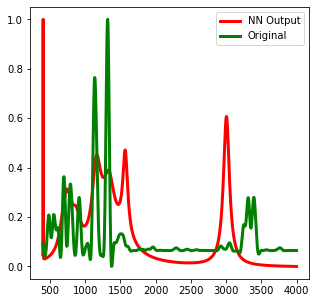

In [35]:
wave=np.linspace(400,4000,901)
fig,ax=pyplot.subplots(1,1, figsize=(5,5))
ax.plot(wave,pred[1].reshape((901,1)),'r',linewidth=3,label='NN Output')
#ax.plot(wave,Y_recon,'b',linewidth=3,label='Reconstructed')
ax.plot(wave,X_test[ind],'g',linewidth=3, label= 'Original')
ax.legend(loc="upper right")
pyplot.show()

In [36]:
print(pred[0].round())
print(y_test[ind])

[[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[1 0 0 1 0 0 0 0 0 1 0 0 0]


In [56]:
wt=model.layers[8].get_weights()
wt1=model.layers[10].get_weights()
wt2=model.layers[9].get_weights()
print('------------------------Gamma--------------------')
print(wt[1])
print('---------------Sum Weights-----------------')
print(wt1)
print('----------------Sig Weights-----------------')
print(wt2)

------------------------Gamma--------------------
[ 72.51072    57.120792   35.902256  101.66737    29.56556    68.18281
  84.66051    56.45956    67.912155   32.40725    77.5422     34.615086
 159.9694     61.264687  176.26796    96.63508     4.2520146  36.533073
   0.8269087  49.707355 ]
---------------Sum Weights-----------------
[array([[ 7.3575921e-02],
       [ 9.5886886e-02],
       [-0.0000000e+00],
       [ 6.7601926e-05],
       [-0.0000000e+00],
       [ 2.6302306e-02],
       [-0.0000000e+00],
       [ 2.9896477e-02],
       [-0.0000000e+00],
       [ 6.3186981e-02],
       [ 8.5553899e-02],
       [ 2.5847759e-02],
       [ 1.4040120e+00],
       [ 3.9668322e-02],
       [ 7.6239222e-01],
       [ 3.3212916e-03],
       [ 1.2025350e-03],
       [-0.0000000e+00],
       [ 5.5336483e-02],
       [ 1.5163042e-02]], dtype=float32)]
----------------Sig Weights-----------------
[array([[-3.6813587e-02, -1.5150027e-02, -6.5650232e-02,  3.4214661e-04,
        -9.2430174e-02, -1.07

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 901, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 901, 10)      60          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 450, 10)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 450, 10)      510         ['max_pooling1d[0][0]']          
                                                                                              

In [55]:
newmod=keras.Model(model.input,model.layers[7].output)
x0=newmod.predict(np.expand_dims(X_test[ind],axis=0))
print(x0@wt[0])

1/1 [==============================] - 0s 69ms/step
[[ 64890.555   -7730.7686  62273.074   89422.445   15659.493   63024.22
    7532.898   49987.73    -8007.0166  57083.312   54375.457   47279.746
   -5330.151   54576.93   -11270.295  -11099.08    67420.19     4520.674
  -10351.006   64089.957 ]]


In [15]:
model.save('SavedModels/NewArch_WithPooling_09032323')

INFO:tensorflow:Assets written to: SavedModels/NewArch_WithPooling_09032323\assets


INFO:tensorflow:Assets written to: SavedModels/NewArch_WithPooling_09032323\assets
